# Weak Lensing Uncertainty Challenge - Starting Kit (PSAnalysis)
***

In the universe, massive objects like galaxies and clusters of galaxies bend the path of light traveling near them — a phenomenon known as gravitational lensing, as predicted by Einstein’s general relativity. When this bending is subtle, it’s known as weak gravitational lensing. It slightly distorts the shapes of distant galaxies as their light travels through the cosmic web of matter, including dark matter and ordinary matter (baryons), on its way to Earth.

By carefully measuring these tiny distortions across the sky, we can reconstruct convergence maps — essentially cosmic “heat maps” that show where matter is concentrated, even if that matter is invisible. These maps let us trace the hidden structure of the universe.

Crucially, weak lensing maps contain rich cosmological information. By statistically analyzing the patterns in these distortions, we can learn about the universe’s content and evolution. For example, we can estimate how much dark matter and dark energy exist, how fast the universe is expanding, and how structures have grown over time. In this way, weak lensing helps us constrain our cosmological model.

Currently, the most widely accepted model of the universe is called $\Lambda$CDM (Lambda Cold Dark Matter). It describes a universe dominated by dark energy (represented by the Greek letter $\Lambda$, or Lambda) and cold dark matter, with only a small fraction made up of normal matter like stars and planets. Weak lensing is one of the most powerful tools we have to test and refine this model.

The goal of this data challenge is to weak lensing convergence maps to constrain the physical parameters of ΛCDM model, $\Omega_m$, which describes what fraction of the universe’s total energy is made of matter (both normal and dark matter), and $S_8$, which measures of how “clumpy” the matter in the universe is on large scales.

***

# 0 - Imports & Settings

In [1]:
import os
import json
import time
import zipfile
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# update this if your data is stored somewhere else
DATA_DIR = '/global/homes/r/ragansu/cosmo_data/'

# 1 - Helper Classes for
- Utitlity Functions
- Data Loading
- Visualizations
- Scoring Functions

### Utility

In [3]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        """
        Add noise to a noiseless convergence map.

        Parameters
        ----------
        data : np.array
            Noiseless convergence maps.
        mask : np.array
            Binary mask map.
        ng : float
            Number of galaxies per arcmin². This determines the noise level; a larger number means smaller noise.
        pixel_size : float, optional
            Pixel size in arcminutes (default is 2.0).
        """

        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask
    
    @staticmethod
    def load_np(data_dir, file_name):
        file_path = os.path.join(data_dir, file_name)
        return np.load(file_path)

    @staticmethod
    def save_np(data_dir, file_name, data):
        file_path = os.path.join(data_dir, file_name)
        np.save(file_path, data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        """
        Save a dictionary with 'means' and 'errorbars' into a JSON file,
        then compress it into a ZIP file inside submission_dir.

        Parameters
        ----------
        submission_dir : str
            Path to the directory where the ZIP file will be saved.
        file_name : str
            Name of the ZIP file (without extension).
        data : dict
            Dictionary with keys 'means' and 'errorbars'.

        Returns
        -------
        str
            Path to the created ZIP file.
        """
        os.makedirs(submission_dir, exist_ok=True)

        json_path = os.path.join(submission_dir, json_file_name)

        # Save JSON file
        with open(json_path, "w") as f:
            json.dump(data, f)

        # Path to ZIP
        zip_path = os.path.join(submission_dir, zip_file_name)

        # Create ZIP containing only the JSON
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)

        # Remove the standalone JSON after zipping
        os.remove(json_path)

        return zip_path

### Data

In [4]:
class Data:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.viz_label_file = 'label.npy'
        self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
        self.label_file = self.viz_label_file
        self.Ncosmo = 101  # Number of cosmologies in the entire training data
        self.Nsys = 256    # Number of systematic realizations in the entire training data
        self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
        self.Ntest = 4000  # Number of instances in the test data
        
        # Number of instances in the sampled test data
        
        self.shape = [1424,176] # dimensions of each map 
        self.pixelsize_arcmin = 2 # pixel size in arcmin
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi # pixel size in radian
        self.ng = 30  # galaxy number density. This determines the noise level of the experiment. Do not change this number.

    def load_train_data(self):
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file) # A binary map that shows which parts of the sky are observed and which areas are blocked
        self.kappa = np.zeros((self.Ncosmo, self.Nsys, *self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file) # Training convergence maps

        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file) # Training labels (cosmological and physical paramameters) of each training map
        self.viz_label = Utility.load_np(data_dir=self.data_dir, file_name=self.viz_label_file) # For visualization of parameter distributions

    def generate_noise_data(self):
        # --- Train data ---
        kappa = self.kappa.copy()
        for i in range(self.Ncosmo):
            for j in range(self.Nsys):
                kappa[i, j] = Utility.add_noise(kappa[0,0], self.mask, self.ng, self.pixelsize_arcmin)        

        return kappa
    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest, *self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file) # Test noisy convergence maps

### Visualization

In [5]:
class Visualization:
    
    @staticmethod
    def plot_mask(mask):
        plt.figure(figsize=(30,100))
        plt.imshow(mask.T)
        plt.show()

    @staticmethod
    def plot_noiseless_training_convergence_map(kappa):
        plt.figure(figsize=(30,100))
        plt.imshow(kappa[0,0].T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_noisy_training_convergence_map(kappa, mask, pixelsize_arcmin, ng):
        plt.figure(figsize=(30,100))
        plt.imshow(Utility.add_noise(kappa[0,0], mask, ng, pixelsize_arcmin).T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_cosmological_parameters_OmegaM_S8(label):
        plt.scatter(label[:,0,0], label[:,0,1])
        plt.xlabel(r'$\Omega_m$')
        plt.ylabel(r'$S_8$')
        plt.show()

    @staticmethod
    def plot_baryonic_physics_parameters(label):
        plt.scatter(label[0,:,2], label[0,:,3])
        plt.xlabel(r'$T_{\mathrm{AGN}}$')
        plt.ylabel(r'$f_0$')
        plt.show()

    @staticmethod
    def plot_photometric_redshift_uncertainty_parameters(label):
        plt.hist(label[0,:,4], bins=20)
        plt.xlabel(r'$\Delta z$')
        plt.show()

### Score 

In [6]:
class Score:
    @staticmethod
    def _score_phase1(true_cosmo, infer_cosmo, errorbar):
        """
        Computes the log-likelihood score for Phase 1 based on predicted cosmological parameters.

        Parameters
        ----------
        true_cosmo : np.ndarray
            Array of true cosmological parameters (shape: [n_samples, n_params]).
        infer_cosmo : np.ndarray
            Array of inferred cosmological parameters from the model (same shape as true_cosmo).
        errorbar : np.ndarray
            Array of standard deviations (uncertainties) for each inferred parameter 
            (same shape as true_cosmo).

        Returns
        -------
        np.ndarray
            Array of scores for each sample (shape: [n_samples]).
        """
        
        sq_error = (true_cosmo - infer_cosmo) ** 2
        scale_factor = 1000  # This is a constant that scales the error term.
        return - np.sum(sq_error / errorbar ** 2 + np.log(errorbar**2) + scale_factor * sq_error, 1)

# 2 - Load train and test data

In [7]:
# Initialize Data class object
data_obj = Data(data_dir=DATA_DIR)

# Load train data
data_obj.load_train_data()

# Load test data
data_obj.load_test_data()

The training maps are generated by 101 cosmological models, each model contains 256 realizations with different systematic / nuisance parameters. So the shape of the training maps kappa is (101, 256, 1424, 176). 

Each training map is associated with 5 parameters, so the shape of label is (101, 256, 5). The first two parameters are cosmological parameters $\Omega_m$ and $S_8$, while the rest three parameters are nuisance parameters that describe systematic effects and need to be marginalized in the data analysis (Two of them describe baryonic effects and the last one describe photometric redshift uncertainties)

In [8]:
print(data_obj.kappa.shape, data_obj.mask.shape, data_obj.label.shape)

(101, 256, 1424, 176) (1424, 176) (101, 256, 5)


# 3 - Visualization

### 2D training maps

survey mask: a binary map that shows which parts of the sky are observed (yellow) and which areas are blocked (purple)

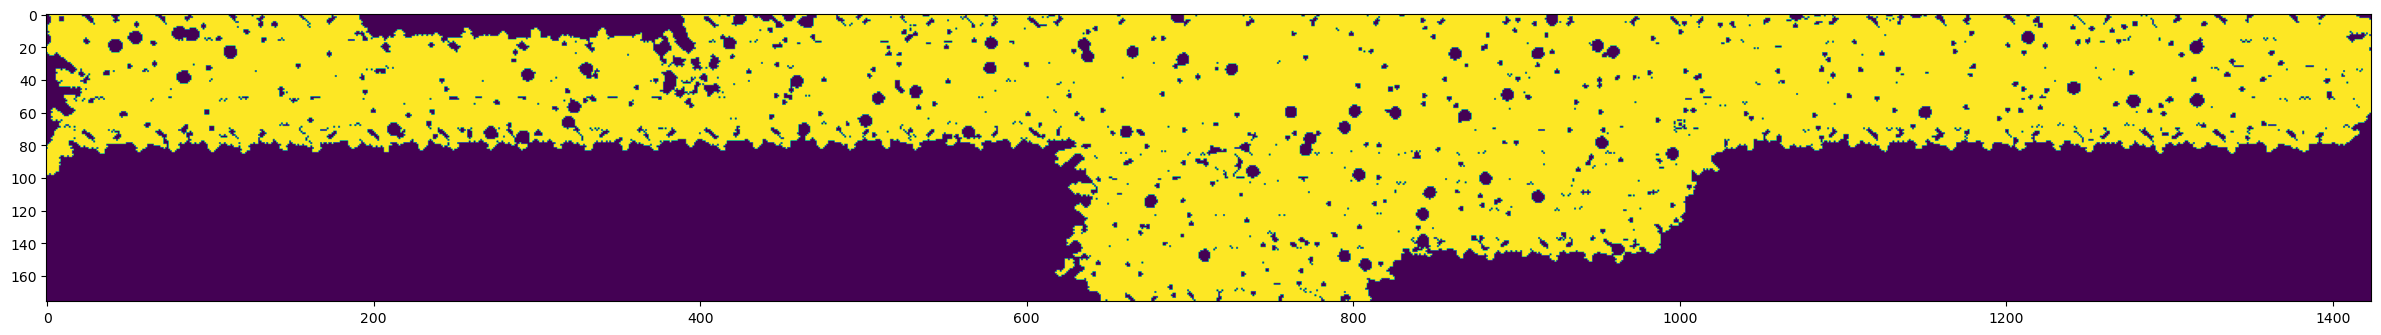

In [9]:
# mask
Visualization.plot_mask(mask=data_obj.mask)

noiseless training convergence map: The convergence maps show the projected matter density (including dark matter and ordinary matter) in the simulated universe, under the Born approximation. On large scales, we can see the matter forms web-like structures (cosmic web) in the universe. The dense regions in these maps, called dark matter halos, are the sites where galaxies form and reside.

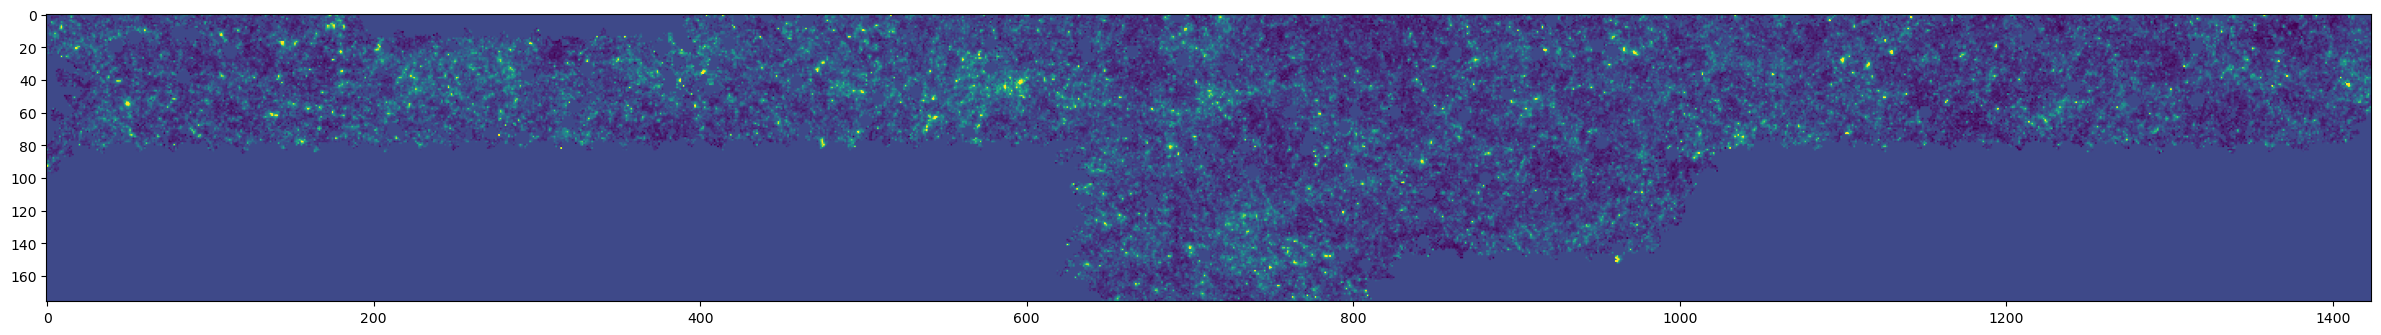

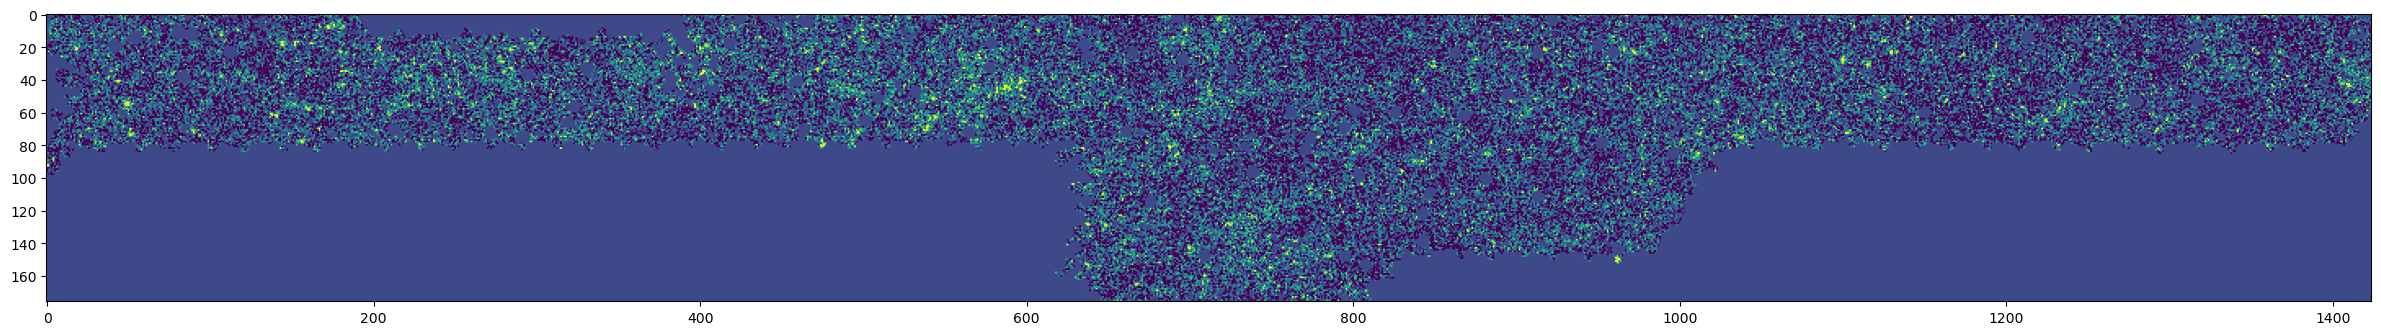

In [10]:
# noiseless training convergence map
Visualization.plot_noiseless_training_convergence_map(kappa=data_obj.kappa)
Visualization.plot_noiseless_training_convergence_map(kappa=data_obj.generate_noise_data())

noisy training convergence map: We add Gaussian noise to the data. This mimics the observed data. During training the noise can be added on the fly with different realizations.

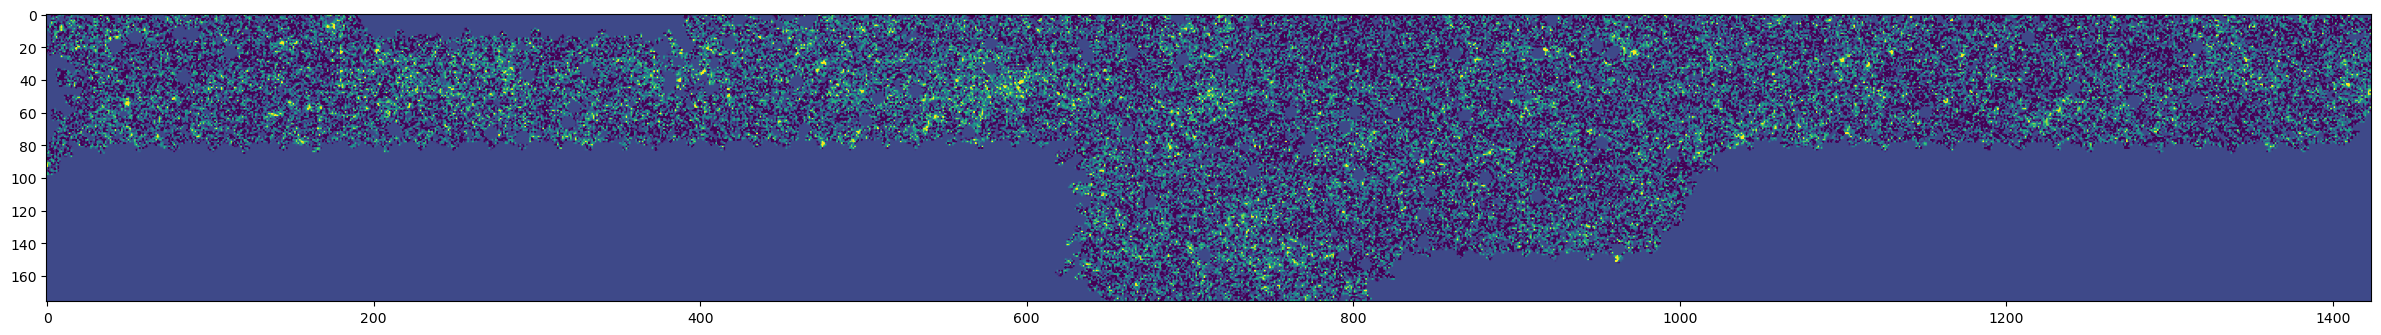

In [11]:
# noisy training convergence map
Visualization.plot_noisy_training_convergence_map(kappa=data_obj.kappa,
                                                  mask=data_obj.mask,
                                                  pixelsize_arcmin=data_obj.pixelsize_arcmin,
                                                  ng=data_obj.ng)

### Distribution of physical parameters

Distribution of cosmological parameters $\Omega_m$ and $S_8$. The density increases towards fiducial cosmology. Note that this distribution introduces a prior in the analysis. The test data cosmology follows the same distribution as the training data.

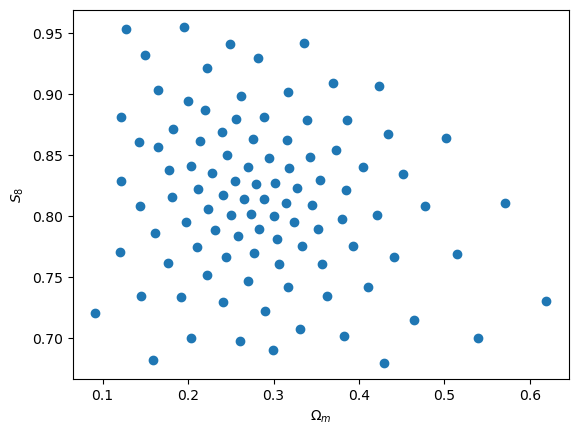

In [12]:
Visualization.plot_cosmological_parameters_OmegaM_S8(label=data_obj.label)

Distribution of baryonic physics parameters. These are nuisance parameters and should be marginalized in the analysis. They follow a uniform distribution within the prior range $T_{\mathrm{AGN}} \in [7.2, 8.5]$, $f_0 \in [0, 0.0265]$

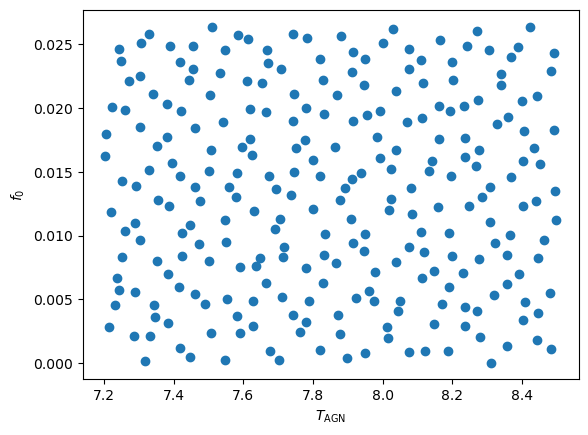

In [13]:
Visualization.plot_baryonic_physics_parameters(label=data_obj.label)

Distribution of photometric redshift uncertainty parameters. This is a nuisance parameter and should be marginalized in the analysis. It follows a Gaussian distribution with mean 0 and std 0.022

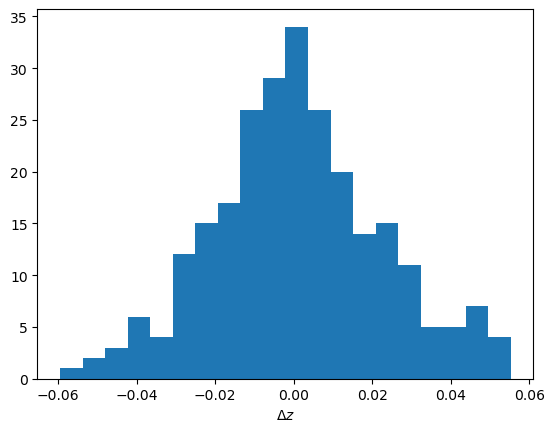

In [14]:
Visualization.plot_photometric_redshift_uncertainty_parameters(label=data_obj.label)

# 4 - Training (build DACNN)

Domain-Adversarial Training of Neural Networks (DANN)  is a technique used in machine learning for domain adaptation, which in our case is accounting for systematic uncertainty. Systematic uncertainty often results in the shift of the domain. 

The DANN algorithm consists of two main components: a parameter regressor and a feature extractor. The  domain classifier is another neural network that predicts the domain of the input data, while the feature extractor is a neural network that learns to extract features from the input data. During training, a domain-adversarial loss is introduced that encourages the feature extractor to produce domain-invariant features that cannot be used to predict the domain. DANN is  trained to minimize the domain-adversarial loss and maximize the accuracy of the main task.

<center>
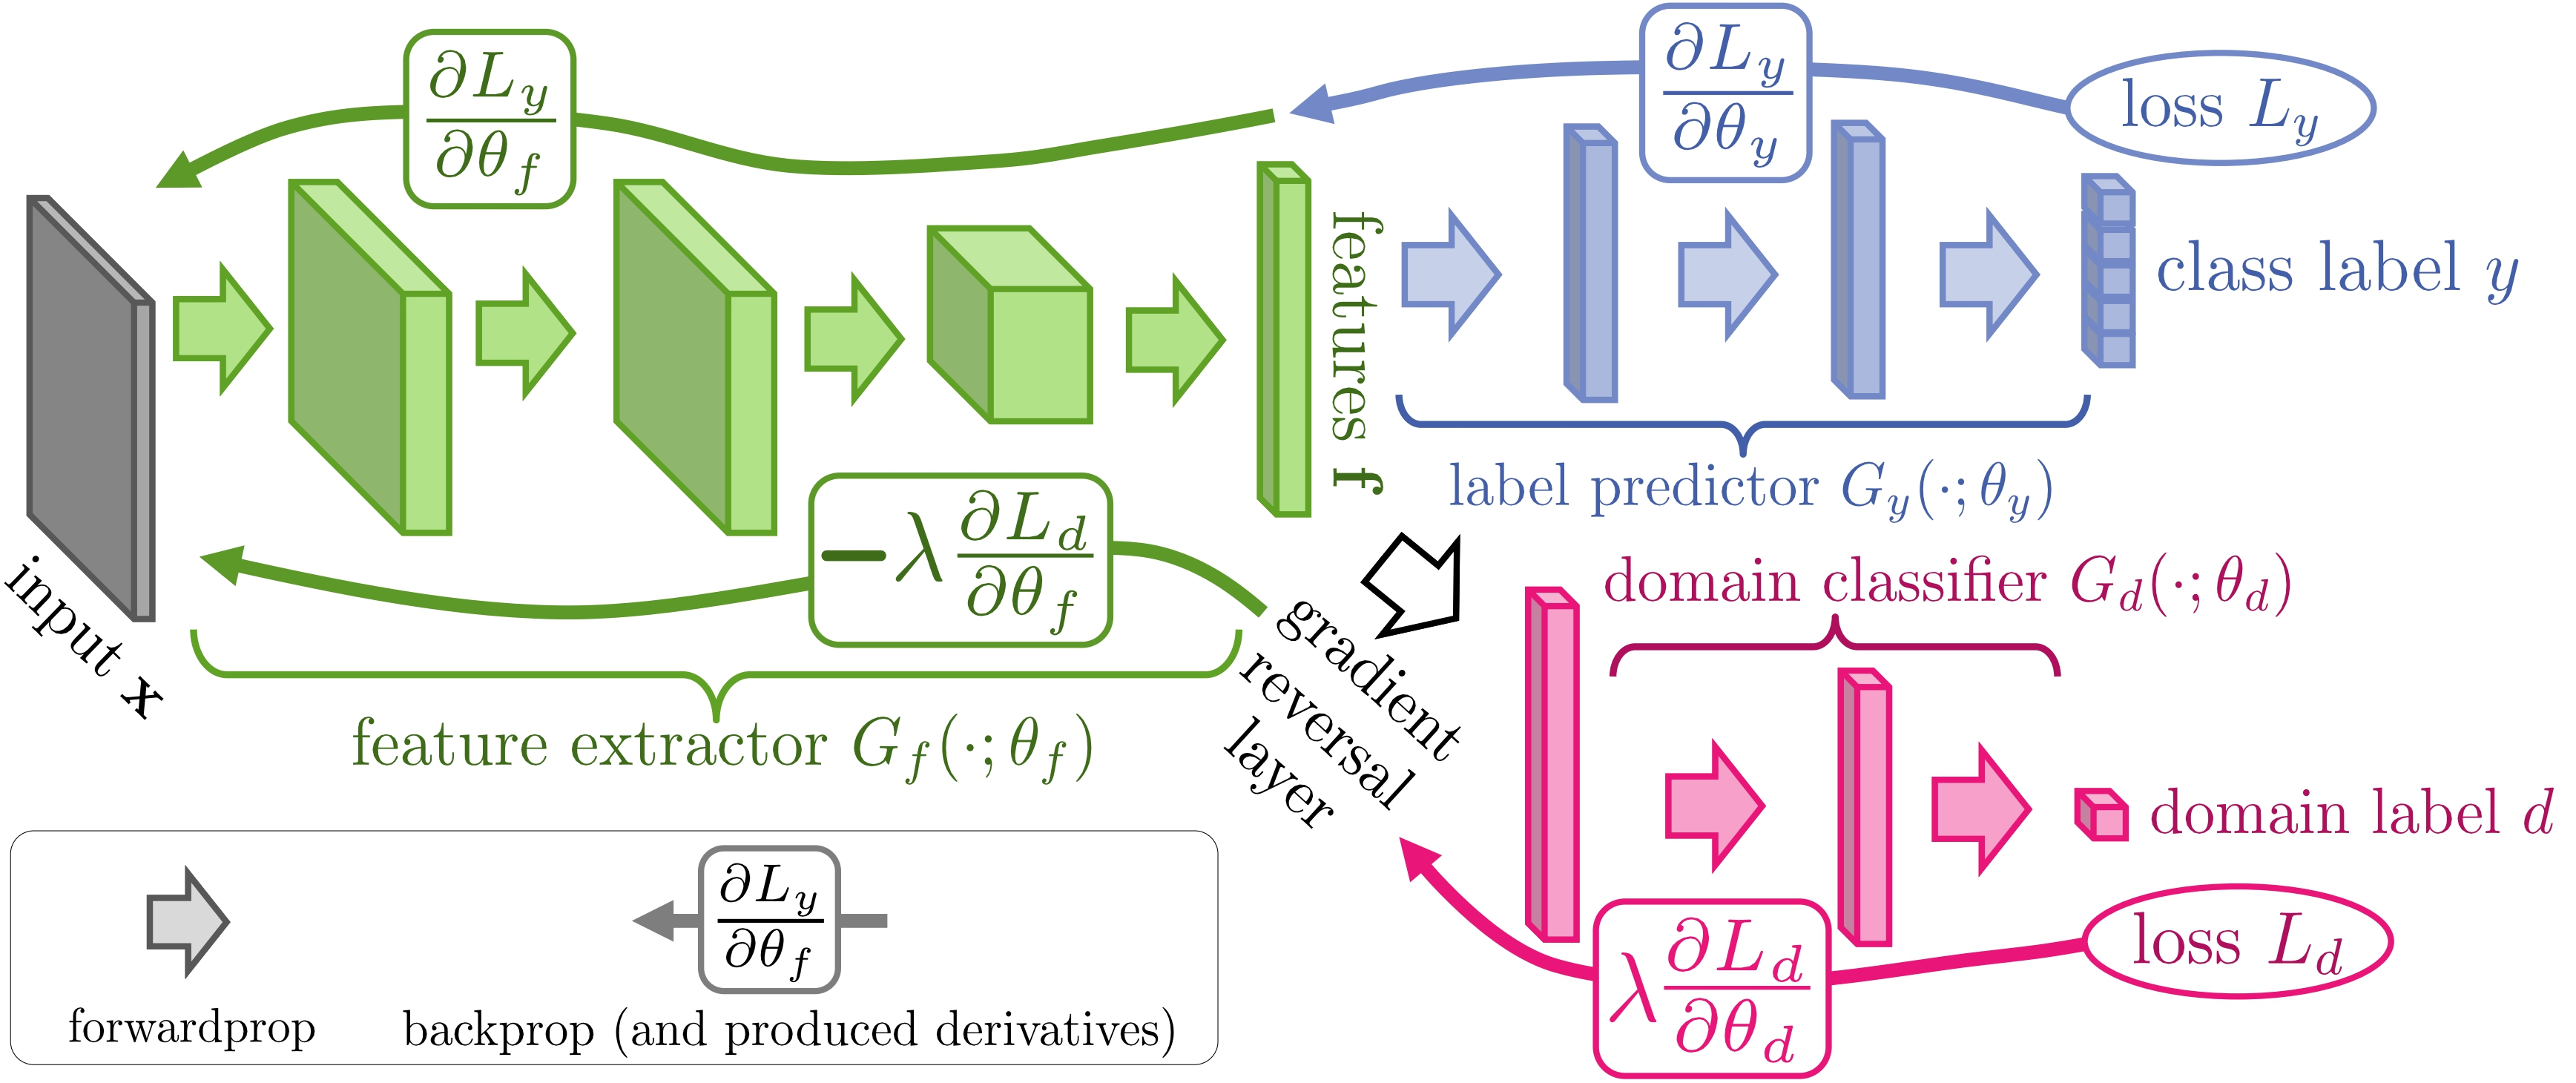 
</center>

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model as KerasModel

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # what to track
    factor=0.5,           # multiply LR by 0.5
    patience=10,           # wait 5 epochs without improvement
    min_lr=1e-7,          # lower bound for LR
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=30
    ,          # wait 10 epochs before stopping
    restore_best_weights=True,  # roll back to best model
    verbose=1
)

hp_lambda = 1000
scale_factor = 1000

def cosmological_loss(scale_factor=1.0):
    def loss(y_true, y_pred):
        infer_cosmo = y_pred[:, :2]
        errorbar = y_pred[:, 2:]
        
        sq_error = tf.square(y_true - infer_cosmo)
        
        # CLAMP all terms to prevent numerical issues
        term1 = sq_error / (tf.square(errorbar) + 1e-3)
        term2 = tf.math.log(tf.square(errorbar) + 1e-3)
        
        total_loss = tf.reduce_sum(term1 + term2 + scale_factor * sq_error)


        if tf.equal(tf.constant(0), tf.math.mod(tf.constant(1), tf.constant(1000))):
            tf.print("Term1 mean:", tf.reduce_mean(term1))
            tf.print("Term2 mean:", tf.reduce_mean(term2)) 
            tf.print("Sq_error mean:", tf.reduce_mean(sq_error))
            tf.print("Errorbar mean:", tf.reduce_mean(errorbar))        
        # Clip the final loss to prevent NaN
        return tf.reduce_mean(total_loss)
    
    return loss

@tf.custom_gradient
def grad_reverse(x, scale=0.2):
#def grad_reverse(x, scale=1.):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy * scale
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super(GradReverse, self).__init__()

    def call(self, x):
        return grad_reverse(x)
    
def build_kappa_cnn(input_shape=(1424, 176, 1), num_labels=5):
    """
    CNN for predicting cosmological parameters from convergence maps.
    
    Args:
        input_shape: shape of each input map (H, W, 1)
        num_labels: number of target labels (dimension of self.label)
    """    
    # Open a strategy scope.
    with strategy.scope():
        
        inputs = layers.Input(shape=input_shape)
        
        # # Add Gaussian Noise Layer (regularisation during training)
        # x = layers.GaussianNoise(0.1)(inputs)
        
        # Enhanced convolutional blocks with dropout and batch norm
        x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)
    
        x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)
        
        x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)
            
        x = layers.Flatten()(x)

        middle_point = layers.Dense( 128, activation="relu", kernel_regularizer='l2')(x)
    
        Dx = layers.Dense(128, activation="relu", kernel_regularizer='l2')(middle_point)
        Dx = layers.Dense( 64, activation="relu", kernel_regularizer='l2')(Dx)
        Dx = layers.Dense( 64, activation="relu", kernel_regularizer='l2')(Dx)

        cosmo_output = layers.Dense(num_labels, name='cosmo_params', activation='linear')(Dx)
    
        # Error estimates (use softplus activation to ensure positivity)
        error_output = layers.Dense(num_labels, activation='linear', name='error_estimates')(Dx)
        
        # Combine outputs
        combined_output = layers.Concatenate(name='combined_output')([cosmo_output, error_output])
    
        GRx = GradReverse()(middle_point)
        Rx = layers.Dense(128, activation="relu")(GRx)
        Rx = layers.Dense(64, activation='relu', kernel_regularizer='l2')(Rx)
        Rx = layers.Dense(64, activation='relu', kernel_regularizer='l2')(Rx)

        Rx = layers.Dense(1, activation="linear", name="Adv")(Rx)

        model = KerasModel(inputs=inputs, outputs=[combined_output, Rx])

        print("[*] ---- Compiling Model")

        model.compile(
            loss={"combined_output": cosmological_loss(scale_factor=scale_factor), "Adv": "mean_squared_error"},
            loss_weights={"combined_output": 1, "Adv": hp_lambda},
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-4,  
                clipvalue=0.5,       
                clipnorm=1.0         
            )
        )

        # model.compile(
        #     loss= "mean_squared_error",
        #     optimizer=tf.keras.optimizers.Adam(
        #         learning_rate=1e-4,  
        #         clipvalue=0.5,       
        #         clipnorm=1.0         
        #     )
        # )
       
    return model


2025-08-31 08:01:48.961018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-31 08:01:48.961045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-31 08:01:48.962197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-31 08:01:48.968755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 08:01:51.414810: W tensorflow/compiler/tf2

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-08-31 08:02:01.242213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79077 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-08-31 08:02:01.243821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79077 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-08-31 08:02:01.245351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79077 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2025-08-31 08:02:01.247807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79077 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

Number of devices: 4


In [16]:
from sklearn.model_selection import train_test_split
Ncosmo = data_obj.Ncosmo
Nsys = data_obj.Nsys
NP_idx = np.arange(Nsys)  # The indices of Nsys nuisance parameter realizations
split_fraction = 0.2      # Set the fraction of data you want to split (between 0 and 1)
seed = 5566               # Define your random seed for reproducible results

train_NP_idx, val_NP_idx = train_test_split(NP_idx, test_size=split_fraction,
                                            random_state=seed)

mask=data_obj.mask,
pixelsize_arcmin=data_obj.pixelsize_arcmin,
ng=data_obj.ng

# data = Utility.add_noise(data_obj.kappa, mask, ng, 2)
data = data_obj.generate_noise_data()


kappa_train = data[:, train_NP_idx]         # shape = (Ncosmo, Ntrain, 1424, 176)
label_train = data_obj.label[:, train_NP_idx]         # shape = (Ncosmo, Ntrain, 5)
kappa_val = data[:, val_NP_idx]             # shape = (Ncosmo, Nval, 1424, 176)
label_val = data_obj.label[:, val_NP_idx]             # shape = (Ncosmo, Nval, 5)

#===========================

X_train = kappa_train.reshape(-1, data_obj.shape[0], data_obj.shape[1], 1)
y_train = label_train.reshape(-1, 5)

X_val = kappa_val.reshape(-1, data_obj.shape[0], data_obj.shape[1], 1)
y_val = label_val.reshape(-1, 5)

y_train_adv = y_train[:, 2:]  # Columns 2,3 and 4
y_train_reg = y_train[:, :2]  # Columns 0 and 1

y_val_adv = y_val[:, 2:]  # Columns 2,3 and 4
y_val_reg = y_val[:, :2]  # Columns 0 and 1



rx_train_labels = np.ones((len(y_train), 1), dtype=np.float32) * 0.5

rx_val_labels = np.ones((len(y_val), 1), dtype=np.float32) * 0.5



# If num_labels doesn't match your actual label dimension, fix it:
num_labels = y_train.shape[1]  # This should give you the correct number

print(f"y_train shape: {y_train_adv.shape}")
print(f"num_labels value: {num_labels}")
tf.keras.backend.clear_session()

try:
    del model
except :
    pass

model = build_kappa_cnn(input_shape=(1424, 176, 1), num_labels=2)
# 
model.summary()

# Stop training if no improvement after patience epochs

# Fit the model
history = model.fit(X_train, [y_train_reg,rx_train_labels], 
                    epochs=100, 
                    batch_size=16, 
                    validation_data=(X_val, [y_val_reg,rx_val_labels]),
                    callbacks=[reduce_lr,early_stop],
                    shuffle=True)




y_train shape: (20604, 3)
num_labels value: 5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:

2025-08-31 08:05:44.889550: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: replica_1/loss/cond/branch_executed/_191
2025-08-31 08:05:46.182962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-08-31 08:05:46.186233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-08-31 08:05:46.207465: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-08-31 08:05:46.211849: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-08-31 08:05:50.179782: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0f30667f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-31 08:05:50.179798: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 

1288/1288 [==============================] - ETA: 0s - loss: 1101291.3750 - combined_output_loss: 16116.8057 - Adv_loss: 1085.1648   

2025-08-31 08:06:25.308946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: loss/cond/branch_executed/_36


1288/1288 [==============================] - 53s 27ms/step - loss: 1101291.3750 - combined_output_loss: 16116.8057 - Adv_loss: 1085.1648 - val_loss: 13594.9434 - val_combined_output_loss: 12892.2480 - val_Adv_loss: 0.6953 - lr: 1.0000e-04
Epoch 2/100
1288/1288 [==============================] - 27s 21ms/step - loss: 7516.6646 - combined_output_loss: 6579.3013 - Adv_loss: 0.9301 - val_loss: 2322.6384 - val_combined_output_loss: 1940.5388 - val_Adv_loss: 0.3746 - lr: 1.0000e-04
Epoch 3/100
1288/1288 [==============================] - 27s 21ms/step - loss: 17709.6641 - combined_output_loss: 4122.5615 - Adv_loss: 13.5795 - val_loss: 884.4421 - val_combined_output_loss: 876.8061 - val_Adv_loss: 1.0304e-04 - lr: 1.0000e-04
Epoch 4/100
1288/1288 [==============================] - 27s 21ms/step - loss: 1492.1101 - combined_output_loss: 1341.8074 - Adv_loss: 0.1429 - val_loss: 726.4039 - val_combined_output_loss: 684.9799 - val_Adv_loss: 0.0341 - lr: 1.0000e-04
Epoch 5/100
1288/1288 [==========

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import json

def plot_loss_curves(history, save_path=None):
    """
    Plot training and validation loss curves for both main and adversarial tasks
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Main task loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Regression Task Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if 'Adv_loss' in history.history:
        # Adversarial task loss
        ax2.plot(history.history['Adv_loss'], label='Training Loss', color='blue')
        ax2.plot(history.history['val_Adv_loss'], label='Validation Loss', color='red')
        ax2.set_title('Adversarial Task Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MSE Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
        # Total loss
        total_train_loss = np.array(history.history['loss']) + hp_lambda * np.array(history.history['Adv_loss'])
        total_val_loss = np.array(history.history['val_loss']) + hp_lambda * np.array(history.history['val_Adv_loss'])
        
        ax3.plot(total_train_loss, label='Training Total Loss', color='blue')
        ax3.plot(total_val_loss, label='Validation Total Loss', color='red')
        ax3.set_title('Total Loss (Regr + λ*Adv)')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Total Loss')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Learning rate (if tracked)
    if 'lr' in history.history:
        ax4.plot(history.history['lr'], label='Learning Rate', color='green')
        ax4.set_title('Learning Rate Schedule')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
    else:
        ax4.remove()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss curves saved to {save_path}")
    
    plt.show()
    

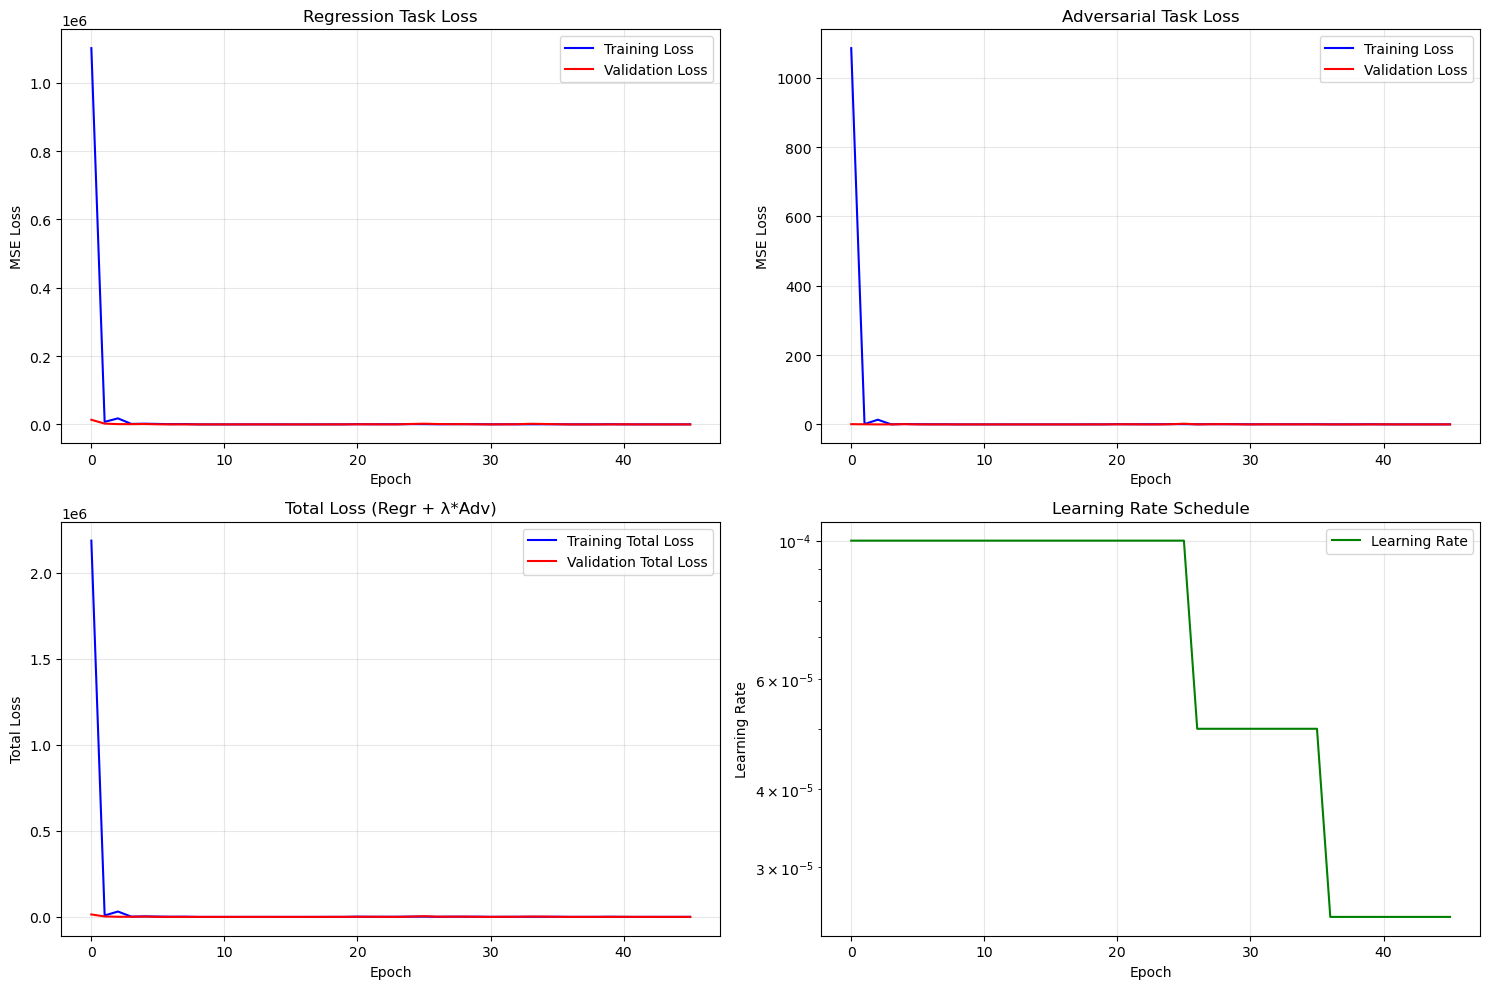

In [18]:
plot_loss_curves(history)

# 5 - Phase one inference

In [19]:
def predict_on_test(model, data, per_gpu_batch=2):
    """
    Run inference on Data().kappa_test, return dict_result with means & errorbars.
    """
    num_gpus = strategy.num_replicas_in_sync
    global_batch = per_gpu_batch * num_gpus
    
    x_test = data.kappa_test.astype(np.float32)[..., None] # add channel dim

    print(x_test.shape)
    
    ds_test = tf.data.Dataset.from_tensor_slices(x_test)
    ds_test = ds_test.batch(global_batch).prefetch(tf.data.AUTOTUNE)
    
    print("Running predictions on test set...")
    y_pred = model.predict(ds_test, verbose=1)[0]
    
    # Compute mean and errorbars (std dev) for Omega_m_hat and S8_hat
    # Assuming index 0 = Omega_m_hat, index 1 = S8_hat
    dict_result = {"means": [], "errorbars": []}
    for i in range(y_pred.shape[0]):
        Omega_m_hat = float(y_pred[i, 0])
        S8_hat = float(y_pred[i, 1])
        try:
            err_Om = float(y_pred[i, 2])
            err_S8 = float(y_pred[i, 3])
        except:
            err_Om = float(0.2)
            err_S8 = float(0.2)       
        
        dict_result["means"].append([Omega_m_hat, S8_hat])
        dict_result["errorbars"].append([err_Om, err_S8])
    
    return dict_result

In [20]:
data = predict_on_test(model, data_obj)

# Now you can safely serialize to JSON
with open('result.json', 'w') as f:
    json.dump(data, f, indent=2)


(4000, 1424, 176, 1)
Running predictions on test set...
500/500 [==============================] - 5s 5ms/step


# 6 - (Optional) Evaluate the scores

***

You can also test your predictions using a validation set split from the training data. To check the score of model predictions `mean` and `errorbar` on the validation set with labels `label_val`, simply use the `Score._score_phase1` function we provide to obtain the validation score:

***

In [21]:
# validation_score = Score._score_phase1(
#     true_cosmo=mean,
#     infer_cosmo=mean,
#     errorbar=errorbar
# )

# print('averaged score:', np.mean(validation_score))
# print('averaged error bar:', np.mean(errorbar, 0))

# 7 - (Optional) Prepare submission for Codabench

***

This section will save the model predictions `mean` and `errorbar` (both are 2D arrays with shape `(4000, 2)`, where `4000` is the number of test instances and `2` is the number of our parameters of interest) as a dictionary in a JSON file `result.json`. Then it will compress `result.json` into a zip file that can be directly submitted to Codabench.

***

In [22]:
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = 'Submission_' + the_date + '.zip'
zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.json",
    zip_file_name=zip_file_name,
    data=data
)
print(f"Submission ZIP saved at: {zip_file}")

Submission ZIP saved at: submissions/Submission_25-08-31-08-26.zip
